<h1><center>Classification de documents</center></h1>

In [1]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import stanza
from preprocess import * 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import explained_variance_score
from keras.preprocessing.text import Tokenizer
import string
import fasttext
import fasttext.util
from tqdm import tqdm


Using TensorFlow backend.


In [2]:
N = 0.5

In [3]:
FILES_PATH = "annulations/*/*/*"

In [4]:
list_docs = glob.glob(FILES_PATH)

In [5]:
list_docs[:4]

['annulations/annulations/37528667/37528667_44391717.txt',
 'annulations/annulations/37528709/37528709_44391753.txt',
 'annulations/annulations/37528715/37528715_44391759.txt',
 'annulations/annulations/37529042/37529042_44391987.txt']

In [ ]:
with open(list_docs[0],'r', encoding="utf-8") as doc:
    text_1 = doc.read()

In [9]:
text_1

'La Capitale\nAssurances générales\nPOLICE D\'ASSURANCE AUTOMOBILE DU QUÉBEC\nF.P.Q. N° 1 - FORMULAIRE DES PROPRIÉTAIRES\nNuméro de police : 55693821-001\nCONDITIONS PARTICULIÈRES\n• RENOUVELLEMENT de votre police d\'assurance\nArticle 1. NOM ET ADRESSE DE L\'ASSURÉ DÉSIGNÉ\nArticle 2. DURÉE DU CONTRAT\n9212-1300 QUEBEC INC FASRS VASCO UNIVERS DU VOYAGE\nSOULANGES ET TOYOTA CREDIT DU CANADA\n108 RTE 338\nLES COTEAUX QC J7X 1 A2\nDU : 2019-05-27* AU : 2021-05-27\'EXCLUSIVEMENT\n"à 0h 01 selon l\'heure normale à l\'adresse de l\'assuré\ndésigné.\n"La ville et la province de l\'adresse écrite à cet article 1 constituent les lieux d\'usage principal, de remisage et de stationnement du véhicule désigné. Si ce n\'est pas le\ncas, le preneur ou l\'assuré désigné doit le déclarer.\nArticle 3.\nCARACTÉRISTIQUES DU VÉHICULE DÉSIGNÉ 1\n• TOYOTA - CAMRY HYBRID 4P - 2015 - Numéro de série 4T1BD1FK3FU168871 - Location neuf\nArticle 4. GARANTIES / RISQUES : Les risques couverts par le contrat d\'assu

In [36]:
pred = []
text = []
count_utf8 = 0
count_iso = 0 
count_avoid = 0
list_empty_file = []
for i in tqdm(list_docs):
    try:
        with open(i,'r', encoding="utf-8") as doc:
            text_ = doc.read()
            if text_ == '':
                count_avoid += 1 
                list_empty_file.append(i)
                continue
            if len(text_.split()) > 2000:
                count_avoid += 1
                continue
            text.append(text_)
            
            if "not_" in i:
                pred.append("normal")
            else:
                pred.append("annulation")
        count_utf8 += 1 
    except:
        with open(i,'r', encoding="ISO-8859-1") as doc:
            text_ = doc.read()
            if text_ == '':
                count_avoid += 1 
                list_empty_file.append(i)
                continue
            if len(text_.split()) > 2000:
                count_avoid += 1 
                continue
            text.append(text_)
            
            if "not_" in i:
                pred.append("normal")
            else:
                pred.append("annulation")
        count_iso += 1 
    

100%|██████████| 22904/22904 [02:55<00:00, 130.56it/s]


In [37]:
print(f"Number of avoid mail : {count_avoid}")

Number of avoid mail : 2284


In [38]:
print(f"Proportion of files in utf8: {round(100*count_utf8/(count_utf8+count_iso),2)}% ; Proportion of files in ISO-5589-1: {round(100*count_iso/(count_utf8+count_iso),2)}%")

Proportion of files in utf8: 53.72% ; Proportion of files in ISO-5589-1: 46.28%


In [39]:
df = pd.DataFrame(data=np.transpose([text, pred]), columns=["mails", "label"])

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

<h3>Tweeter data</h3>

In [17]:
df_texts = pd.read_csv("french_tweets.csv")

In [18]:
df_texts.shape

(1526724, 2)

In [19]:
df_texts.tail()

,label,text
1526719,1,"Oui, cela fonctionne mieux que de l'attendre à..."
1526720,1,Je viens de me réveiller. Ne pas avoir d'école...
1526721,1,Thewdb.com - très cool d'entendre les vieilles...
1526722,1,Êtes-vous prêt pour votre mojo makeover? Deman...
1526723,1,Joyeux 38ème anniversaire à mon livre de tous ...


In [20]:
df_ = pd.DataFrame()

In [21]:
text_tweet = []
step = 40
j = 0
iter_ = df_texts.shape[0]//step +1
for i in range(iter_):
    
    if j+step < iter_*step :
        text_tweet.append(' '.join(df_texts.text[j:j+step]))
    else:
        text_tweet.append(' '.join(df_texts.text[j:df_texts.shape[0]]))
    j += step
    #print(j)

In [22]:
len(text_tweet[-3].split())

543

In [26]:
df_.loc[:,"mails"] = text_tweet[:10000]

In [24]:
df_.loc[:,"label"] = "normal"

In [25]:
df_.shape, df.shape

NameError: name 'df' is not defined

In [44]:
df = df.append(df_)

In [27]:
df = df_texts.copy()
df.rename(columns={"text":"mails"}, inplace=True)

In [28]:
df = df.sample(frac=1).reset_index(drop=True)

In [29]:
df = df.sample(frac=0.02)

In [30]:
df.head(10)

,label,mails
1430094,1,"Il, il, ce ne sont pas les miens. Mon ami est ..."
432458,1,Occupé aujourd'hui .... les choses continuent ...
713904,0,Six autres CV envoyés. J'ai perdu compte de co...
457229,1,Va voir mike epps samedi à carolines
1161333,1,Est-ce que des pierres traversent l'endroit à ...
625804,1,Est allé au kfc
1306796,0,Oui mais elle m'a dit shh
895428,1,Et le chat numéro un est parti!
724444,1,Vous êtes à mi-chemin pour devenir totalement ...
807390,1,Ont tellement de plaisir !!!!!


In [40]:
df.mails[df.mails==''].count()

0

In [41]:
df.label.value_counts()

normal        11412
annulation     9208
Name: label, dtype: int64

In [43]:
list_empty_file[0]

'annulations/annulations/37688816/37688816_44532759.txt'

In [44]:
test = [i.split("/")[3] for i in list_empty_file]

In [45]:
test[:4]

['37688816_44532759.txt',
 '37688816_44532760.txt',
 '37828658_44659970.txt',
 '37854707_44681937.txt']

In [49]:
np.savetxt("empty_files.txt", test, encoding="utf-8", fmt='%s')

<h2>Name Entity Recognition</h2>

In [ ]:
# Build an English pipeline, with all processors by default
print("Building an French pipeline...")
fr_nlp = stanza.Pipeline('fr', processors="tokenize,mwt,pos,lemma,depparse,ner")

In [152]:
res = fr_nlp(df_.mails[2])

In [153]:
type(res)

stanza.models.common.doc.Document

In [155]:
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in res.sentences for word in sent.words], sep='\n')

id: 1	word: Est	head id: 2	head: terrifiée	deprel: aux:tense
id: 2	word: terrifiée	head id: 6	head: supprimé	deprel: advcl
id: 3	word: ,	head id: 2	head: terrifiée	deprel: punct
id: 4	word: elle	head id: 6	head: supprimé	deprel: nsubj
id: 5	word: a	head id: 6	head: supprimé	deprel: aux:tense
id: 6	word: supprimé	head id: 0	head: root	deprel: root
id: 7	word: accidentellement	head id: 6	head: supprimé	deprel: advmod
id: 8	word: une	head id: 9	head: référence	deprel: det
id: 9	word: référence	head id: 6	head: supprimé	deprel: obj
id: 10	word: dans	head id: 12	head: mission	deprel: case
id: 11	word: sa	head id: 12	head: mission	deprel: det
id: 12	word: mission	head id: 6	head: supprimé	deprel: obl:mod
id: 13	word: de	head id: 14	head: gestion	deprel: case
id: 14	word: gestion	head id: 12	head: mission	deprel: nmod
id: 15	word: et	head id: 16	head: espère	deprel: cc
id: 16	word: espère	head id: 6	head: supprimé	deprel: conj
id: 17	word: qu'	head id: 21	head: heurte	deprel: mark
id: 18	word

In [156]:
print(*[f'entity: {ent.text}\ttype: {ent.type}' for sent in res.sentences for ent in sent.ents], sep='\n')

entity: Amazon	type: MISC
entity: php	type: MISC
entity: Argh!	type: MISC
entity: Chiefdelphi	type: LOC
entity: Jouer à la maison!	type: MISC
entity: Su	type: MISC
entity: Le pauvre joshy	type: MISC
entity: Michigan	type: LOC
entity: Soupir	type: PER
entity: Si	type: MISC
entity: Hey	type: MISC
entity: Oh!	type: MISC
entity: Allemagne	type: LOC
entity: Je suis dans ma cage	type: MISC
entity: La gorge	type: MISC
entity: Aww	type: MISC
entity: Rentrer	type: PER
entity: Noah	type: PER
entity: Dang!	type: MISC
entity: Ha le soleil	type: MISC
entity: Mon homme	type: MISC
entity: Voyage méga majeur	type: MISC
entity: Michigan	type: MISC
entity: OMG	type: MISC
entity: Ma	type: MISC
entity: Proposition	type: LOC
entity: Biof	type: PER
entity: Hey	type: PER
entity: Girlyvue	type: MISC
entity: Oh je-bus!	type: MISC
entity: Rachel!	type: MISC
entity: Une	type: LOC
entity: Serré	type: PER
entity: Mon mari	type: MISC
entity: Jeffree	type: PER
entity: Ma réaction aussi	type: MISC
entity: Ohh	type: P

In [154]:
for i, sentence in enumerate(res.sentences):
    print(f'====== Sentence {i+1} tokens =======')
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

====== Sentence 1 tokens =======
id: 1	text: Est
id: 2	text: terrifiée
id: 3	text: ,
id: 4	text: elle
id: 5	text: a
id: 6	text: supprimé
id: 7	text: accidentellement
id: 8	text: une
id: 9	text: référence
id: 10	text: dans
id: 11	text: sa
id: 12	text: mission
id: 13	text: de
id: 14	text: gestion
id: 15	text: et
id: 16	text: espère
id: 17	text: qu'
id: 18	text: elle
id: 19	text: ne
id: 20	text: se
id: 21	text: heurte
id: 22	text: pas
id: 23	text: quand
id: 24	text: elle
id: 25	text: reviendra
id: 26	text: Amazon
id: 27	text: s3
id: 28	text: plugin
id: 29	text: n'
id: 30	text: a
id: 31	text: pas
id: 32	text: travaillé
id: 33	text: sur
id: 34	text: mon
id: 35	text: site
id: 36	text: .
====== Sentence 2 tokens =======
id: 1	text: Il
id: 2	text: a
id: 3	text: besoin
id: 4	text: de
id: 5	text: php
id: 6	text: 5
id: 7	text: .
====== Sentence 3 tokens =======
id: 1	text: Mais
id: 2	text: mon
id: 3	text: fournisseur
id: 4	text: d'
id: 5	text: hébergement
id: 6	text: n'
id: 7	text: a
id: 8	text: 

<h1>Preprocessing </h1>

The text corpora and other textual data in their native raw formats are normally not
well formatted and standardized and of course we should expect this, after all, text data
is highly unstructured! Text processing or, to be more specific preprocessing, involves a
wide variety of techniques that convert raw text into well-defined sequences of linguistic
components that have standard structure and notation. Additional metadata is often
also present in the form of annotations to give more meaning to the text components like
tags. The following list gives us an idea of some of the most popular text preprocessing
and understanding techniques.

Steps : 
- Removing HTML tags
- Tokenization
- Removing unnecessary tokens and stopwords
- Handling contractions
- Correcting spelling errors
- Stemming
- Lemmatization
- Tagging
- Chunking
- Parsing

> [Chapter 3 processing and understanding Text p.116 - Text Analytics with Python, Dipanjan Sarkar, 2019](https://www.apress.com/gp/book/9781484243534)

Tomas Mikolov is one of the developers of word2vec, a popular word embedding method. He suggests only very minimal text cleaning is required when learning a word embedding model.
Below is his response when pressed with the question about how to best prepare text data for word2vec.

><i>There is no universal answer. It all depends on what you plan to use the vectors for. In my experience, it is usually good to disconnect (or remove) punctuation from words, and sometimes also convert all characters to lowercase. One can also replace all numbers (possibly greater than some constant) with some single token such as .
>
>All these pre-processing steps aim to reduce the vocabulary size without removing any important content (which in some cases may not be true when you lowercase certain words, ie. ‘Bush’ is different than ‘bush’, while ‘Another’ has usually the same sense as ‘another’). The smaller the vocabulary is, the lower is the memory complexity, and the more robustly are the parameters for the words estimated. You also have to pre-process the test data in the same way.</i>
>
>…
>
><i>In short, you will understand all this much better if you will run experiments.</i>

> [How to Clean Text for Machine Learning with Python, Jason Brownlee](https://machinelearningmastery.com/clean-text-machine-learning-python/)

In [ ]:
def func_preproc():
    # Build an English pipeline, with all processors by default
    print("Building an French pipeline...")
    fr_nlp = stanza.Pipeline('fr', processors="tokenize,mwt,pos,lemma,depparse,ner")
    

In [15]:
df.mails = df.mails.str.lower()

In [50]:
df.mails = df.mails.str.replace("\n", " ")

In [51]:
df['char_count'] = df['mails'].apply(len)
df['word_count'] = df['mails'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['mails'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df['mails'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] = df['mails'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

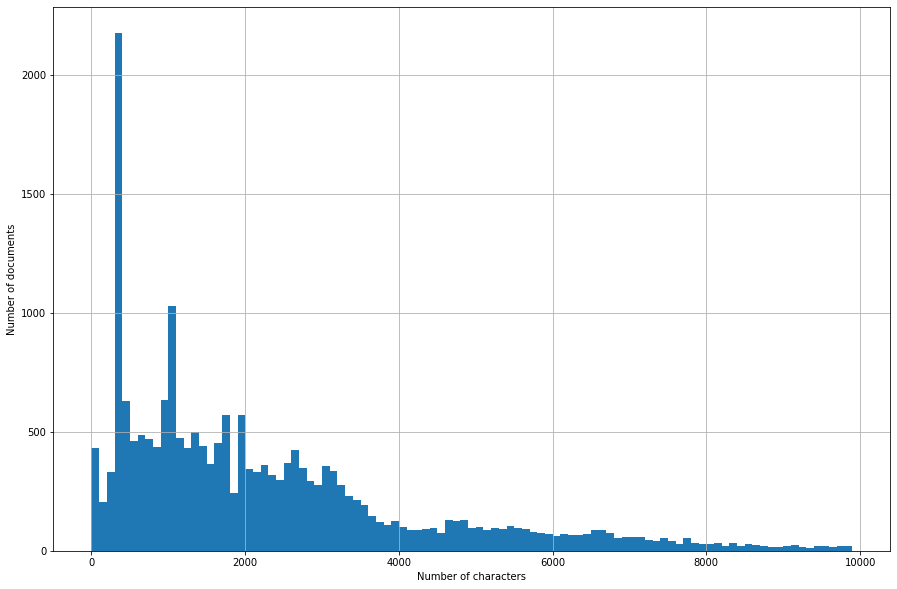

In [52]:
plt.figure(figsize=(15,10))
plt.hist(df.char_count.values, bins = range(0, 10000, 100))
plt.xlabel("Number of characters")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()

In [27]:

def func_keras_tokenize(text):
    tokens = Tokenizer(text)
    return tokens

Using TensorFlow backend.


In [187]:
func_keras_tokenize(text)

In [53]:
def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

In [54]:
def func_remove_char_specific(text):
    table = '!"#$%&()*+,./:;<=>?@[\]^_`{|}~•'
    table = str.maketrans('', '', table)
    words = text.split()
    stripped = [w.translate(table) for w in words]
    return ' '.join(stripped)

In [55]:
def func_remove_upper_case(text):
    words = text.split()
    stripped = [w.lower() if w.isupper() else w for w in words]
    return " ".join(stripped)

In [56]:
df.mails = df.mails.apply(remove_whitespace)

In [57]:
df.mails = df.mails.apply(func_remove_char_specific)
df.mails = df.mails.apply(func_remove_upper_case)

In [58]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [59]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['mails'], df['label'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [60]:
train_x[:3]

6545     canassurance compagnie d'assurance assurance d...
17880    La Capitale Assurances générales police d'assu...
13050    Id Courriel geeddspq158379023110554 De marlene...
Name: mails, dtype: object

In [61]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['mails'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [62]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['mails'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)
print("word level tf-idf done")
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df['mails'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)
print("ngram level tf-idf done")
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df['mails'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 
print("characters level tf-idf done")

word level tf-idf done
ngram level tf-idf done


/home/chris/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


characters level tf-idf done


In [63]:
pretrained = fasttext.FastText.load_model('fastText/cc.fr.300.bin')

In [64]:
# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(df['mails'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=300)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=300)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = pretrained.get_sentence_vector(word) #embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 247187/247187 [00:06<00:00, 35684.83it/s]


In [65]:
pretrained.get_dimension()

300

In [66]:
df['char_count'] = df['mails'].apply(len)
df['word_count'] = df['mails'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['mails'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df['mails'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] = df['mails'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [ ]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df['noun_count'] = df['mails'].progress_apply(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] = df['mails'].progress_apply(lambda x: check_pos_tag(x, 'verb'))
df['adj_count'] = df['mails'].progress_apply(lambda x: check_pos_tag(x, 'adj'))
df['adv_count'] = df['mails'].progress_apply(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['mails'].progress_apply(lambda x: check_pos_tag(x, 'pron'))

In [ ]:
df.head()

In [ ]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in tqdm(enumerate(topic_word)):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [67]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [68]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print( "NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print( "NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print( "NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.8397672162948594
NB, WordLevel TF-IDF:  0.8374393792434529
NB, N-Gram Vectors:  0.8267701260911736
NB, CharLevel Vectors:  0.7806013579049467


In [69]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print( "LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print( "LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print( "LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print( "LR, CharLevel Vectors: ", accuracy)

/home/chris/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR, Count Vectors:  0.9342386032977692
LR, WordLevel TF-IDF:  0.9286129970902037
LR, N-Gram Vectors:  0.9016488845780796
LR, CharLevel Vectors:  0.9026188166828322


In [70]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print( "SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.9200775945683802


In [71]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print( "RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print( "RF, WordLevel TF-IDF: ", accuracy)

RF, Count Vectors:  0.9146459747817652
RF, WordLevel TF-IDF:  0.9243452958292919


In [72]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print( "Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print( "Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print( "Xgb, CharLevel Vectors: ", accuracy)

Xgb, Count Vectors:  0.9408341416100873
Xgb, WordLevel TF-IDF:  0.9406401551891368
Xgb, CharLevel Vectors:  0.938894277400582


<h2>Shallow Neural Networks</h2>

In [73]:
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

In [74]:
model = keras.Sequential([
  keras.layers.Embedding(embedding_matrix.shape[0], 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          3955008   
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 3,955,025
Trainable params: 3,955,025
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [76]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
check_p = tf.keras.callbacks.ModelCheckpoint("save_models/model.h5", save_best_only=True)

In [77]:
history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 15s 39ms/step - loss: 0.6721 - accuracy: 0.5843 - val_loss: 0.6447 - val_accuracy: 0.6615
Epoch 2/50
387/387 [==============================] - 12s 31ms/step - loss: 0.6302 - accuracy: 0.7249 - val_loss: 0.6184 - val_accuracy: 0.7404
Epoch 3/50
387/387 [==============================] - 12s 30ms/step - loss: 0.6068 - accuracy: 0.7849 - val_loss: 0.5989 - val_accuracy: 0.7921
Epoch 4/50
387/387 [==============================] - 14s 36ms/step - loss: 0.5897 - accuracy: 0.8239 - val_loss: 0.5869 - val_accuracy: 0.8099
Epoch 5/50
387/387 [==============================] - 10s 26ms/step - loss: 0.5787 - accuracy: 0.8405 - val_loss: 0.5784 - val_accuracy: 0.8212
Epoch 6/50
387/387 [==============================] - 10s 27ms/step - loss: 0.5702 - accuracy: 0.8519 - val_loss: 0.5720 - val_accuracy: 0.8335
Epoch 7/50
387/387 [==============================] - 11s 29ms/step - loss: 0.5632 - accuracy: 0.8624 - val_loss: 0.5672 - val_accuracy:

In [78]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 0s 3ms/step - loss: 0.5335 - accuracy: 0.9015
[0.5334848761558533, 0.9014549255371094]


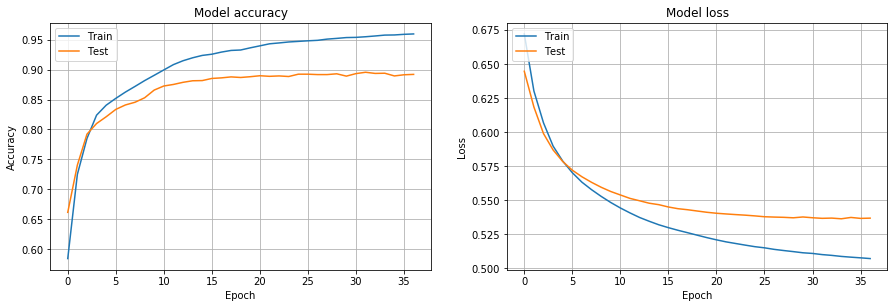

In [79]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

The function [cohen_kappa_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html#sklearn.metrics.cohen_kappa_score) computes [Cohen’s kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa) statistic. This measure is intended to compare labelings by different human annotators, not a classifier versus a ground truth.

The kappa score (see docstring) is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).

Kappa scores can be computed for binary or multiclass problems, but not for multilabel problems (except by manually computing a per-label score) and not for more than two annotators.

In [80]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 80.03%


<h3>Confusion Matrix</h3>

In [81]:
func_confusion_matrix(model, valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,2029,272
Actual Positive,236,2618


<h3>Classification repport</h3>

In [82]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2301
           1       0.91      0.92      0.91      2854

    accuracy                           0.90      5155
   macro avg       0.90      0.90      0.90      5155
weighted avg       0.90      0.90      0.90      5155



<h3>ROC and AUC Curve</h3>

Instructions for updating:
Please use `model.predict()` instead.


2020-04-14 13:13:13 WARNING: From /home/chris/preprocess.py:78: Sequential.predict_proba (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use `model.predict()` instead.


No Skill: ROC AUC=0.500
NN: ROC AUC=0.957


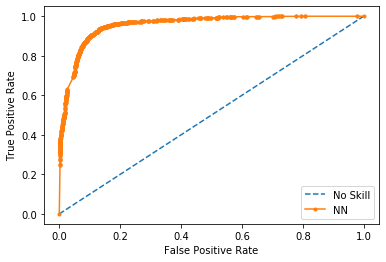

In [83]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

Model: f1=0.912 auc=0.962


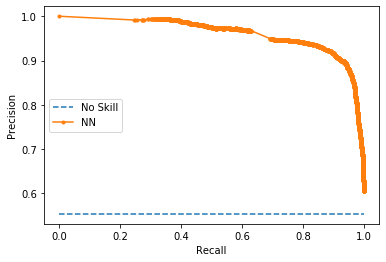

In [84]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h3>Balanced Accuracy</h3>

Compute the balanced accuracy

The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

The best value is 1 and the worst value is 0 when adjusted=False

In [85]:
print(f"The balanced accuracy is : {round(100*balanced_accuracy_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

The balanced accuracy is : 89.95%


In [86]:
print(f"The Zero-one Loss is : {round(100*zero_one_loss(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

The Zero-one Loss is : 9.85%


In [87]:
explained_variance_score(valid_y, model.predict(valid_seq_x))

0.6778216976773314

<h2>Deep Neural Networks</h2>

In [88]:
model = keras.Sequential([
  keras.layers.Embedding(embedding_matrix.shape[0], 50),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          12359400  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 12,360,233
Trainable params: 12,360,233
Non-trainable params: 0
_________________________________________________________________


In [89]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [90]:
y_train = np.asarray(train_y).astype('float32').reshape((-1,1))
y_test = np.asarray(valid_y).astype('float32').reshape((-1,1))

In [91]:
history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 188s 487ms/step - loss: 0.6410 - accuracy: 0.7542 - val_loss: 0.5838 - val_accuracy: 0.8096
Epoch 2/50
387/387 [==============================] - 154s 399ms/step - loss: 0.5660 - accuracy: 0.8567 - val_loss: 0.5575 - val_accuracy: 0.8577
Epoch 3/50
387/387 [==============================] - 159s 410ms/step - loss: 0.5426 - accuracy: 0.8973 - val_loss: 0.5478 - val_accuracy: 0.8768
Epoch 4/50
387/387 [==============================] - 162s 418ms/step - loss: 0.5305 - accuracy: 0.9193 - val_loss: 0.5420 - val_accuracy: 0.8872
Epoch 5/50
387/387 [==============================] - 155s 401ms/step - loss: 0.5224 - accuracy: 0.9340 - val_loss: 0.5402 - val_accuracy: 0.8859
Epoch 6/50
387/387 [==============================] - 159s 412ms/step - loss: 0.5177 - accuracy: 0.9416 - val_loss: 0.5374 - val_accuracy: 0.8933
Epoch 7/50
387/387 [==============================] - 176s 455ms/step - loss: 0.5147 - accuracy: 0.9453 - val_loss: 0.5364 -

In [92]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 0s 2ms/step - loss: 0.5325 - accuracy: 0.9022
[0.5325073003768921, 0.9022308588027954]


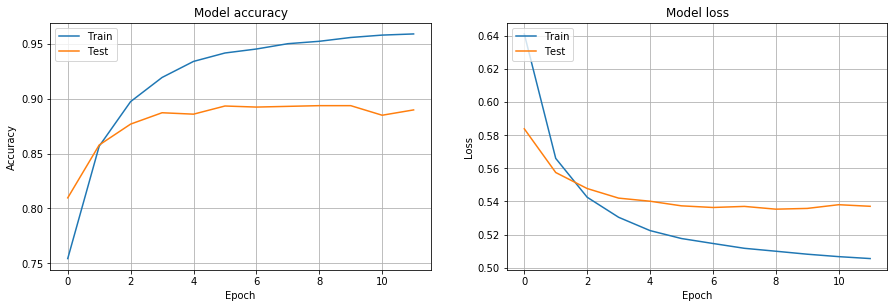

In [93]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [94]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 80.16%


<h3>Confusion Matrix</h3>

In [95]:
func_confusion_matrix(model, valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,2012,289
Actual Positive,215,2639


<h3>Classification repport</h3>

In [96]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2301
           1       0.90      0.92      0.91      2854

    accuracy                           0.90      5155
   macro avg       0.90      0.90      0.90      5155
weighted avg       0.90      0.90      0.90      5155



<h3>ROC and AUC Curve</h3>

No Skill: ROC AUC=0.500
NN: ROC AUC=0.954


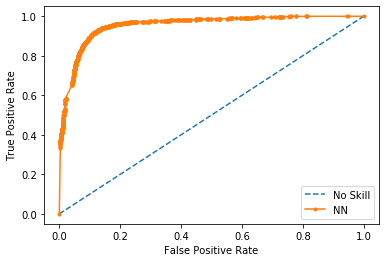

In [97]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

Model: f1=0.913 auc=0.960


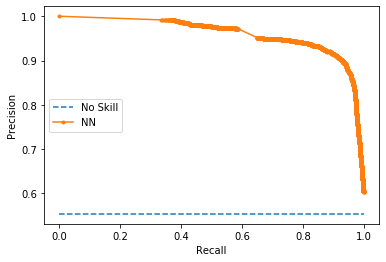

In [98]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

In [99]:
model = keras.Sequential([
  keras.layers.Embedding(embedding_matrix.shape[0], 50),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          12359400  
_________________________________________________________________
global_average_pooling1d_2 ( (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 12,360,505
Trainable params: 12,360,505
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 191s 495ms/step - loss: 0.6164 - accuracy: 0.7564 - val_loss: 0.5661 - val_accuracy: 0.8335
Epoch 2/50
387/387 [==============================] - 219s 565ms/step - loss: 0.5499 - accuracy: 0.8788 - val_loss: 0.5468 - val_accuracy: 0.8765
Epoch 3/50
387/387 [==============================] - 208s 537ms/step - loss: 0.5297 - accuracy: 0.9144 - val_loss: 0.5386 - val_accuracy: 0.8904
Epoch 4/50
387/387 [==============================] - 197s 509ms/step - loss: 0.5204 - accuracy: 0.9313 - val_loss: 0.5386 - val_accuracy: 0.8826
Epoch 5/50
387/387 [==============================] - 236s 609ms/step - loss: 0.5148 - accuracy: 0.9401 - val_loss: 0.5357 - val_accuracy: 0.8927
Epoch 6/50
387/387 [==============================] - 211s 545ms/step - loss: 0.5117 - accuracy: 0.9466 - val_loss: 0.5375 - val_accuracy: 0.8898
Epoch 7/50
387/387 [==============================] - 187s 482ms/step - loss: 0.5098 - accuracy: 0.9497 - val_loss: 0.5349 -

In [101]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 1s 4ms/step - loss: 0.5329 - accuracy: 0.8904
[0.5328608751296997, 0.8903976678848267]


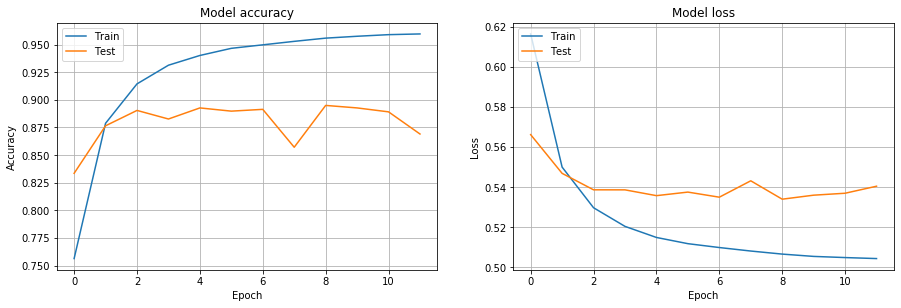

In [102]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [103]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 77.99%


<h3>Confusion Matrix</h3>

In [104]:
func_confusion_matrix(model, valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,2108,193
Actual Positive,372,2482


<h3>Classification repport</h3>

In [105]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2301
           1       0.93      0.87      0.90      2854

    accuracy                           0.89      5155
   macro avg       0.89      0.89      0.89      5155
weighted avg       0.89      0.89      0.89      5155



<h3>ROC and AUC Curve</h3>

No Skill: ROC AUC=0.500
NN: ROC AUC=0.952


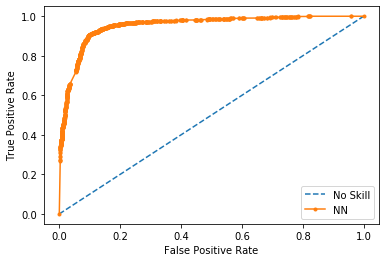

In [106]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

Model: f1=0.898 auc=0.958


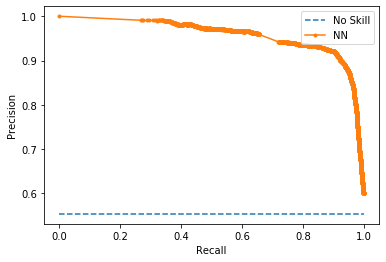

In [107]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

In [108]:
model = keras.Sequential([
  keras.layers.Embedding(embedding_matrix.shape[0], 100),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         24718800  
_________________________________________________________________
global_average_pooling1d_3 ( (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 24,722,577
Trainable params: 24,722,577
Non-trainable params: 0
_________________________________________________________________


In [109]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
 13/387 [>.............................] - ETA: 9:50 - loss: 0.7107 - accuracy: 0.4736

KeyboardInterrupt: 

In [ ]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

In [ ]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [ ]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}")

<h3>Confusion Matrix</h3>

In [ ]:
func_confusion_matrix(model, valid_y, valid_seq_x)

<h3>Classification repport</h3>

In [ ]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

<h3>ROC and AUC Curve</h3>

In [ ]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Recurent Neural Network - RNN</h2>

In [118]:
def create_rnn_model(word_index, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1, activation='sigmoid')])
    
    return model

In [119]:
model = create_rnn_model(word_index , embedding_matrix=embedding_matrix, pre_trained=True )

model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 39s 100ms/step - loss: 0.5655 - accuracy: 0.7030 - val_loss: 0.5195 - val_accuracy: 0.7472
Epoch 2/50
387/387 [==============================] - 46s 118ms/step - loss: 0.5074 - accuracy: 0.7539 - val_loss: 0.5149 - val_accuracy: 0.7501
Epoch 3/50
387/387 [==============================] - 50s 129ms/step - loss: 0.6260 - accuracy: 0.6597 - val_loss: 0.6397 - val_accuracy: 0.6250
Epoch 4/50
387/387 [==============================] - 59s 153ms/step - loss: 0.5872 - accuracy: 0.6912 - val_loss: 0.6166 - val_accuracy: 0.6634
Epoch 5/50
387/387 [==============================] - 54s 139ms/step - loss: 0.5660 - accuracy: 0.7098 - val_loss: 0.5713 - val_accuracy: 0.7051


In [120]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 7s 41ms/step - loss: 0.5547 - accuracy: 0.7251
[0.554710865020752, 0.725121259689331]


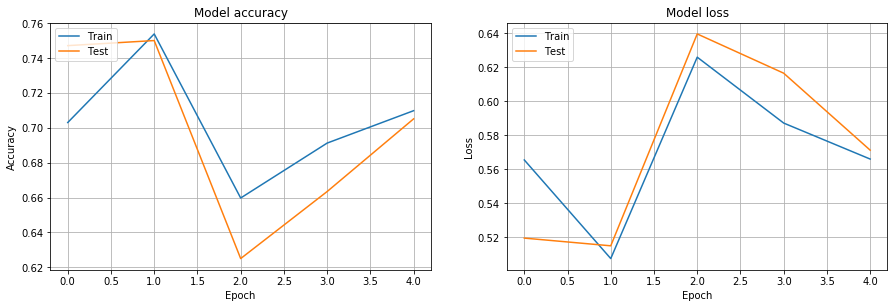

In [121]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [122]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 43.02%


<h3>Confusion Matrix</h3>

In [123]:
func_confusion_matrix(model, valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,1308,993
Actual Positive,424,2430


<h3>Classification repport</h3>

In [124]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      2301
           1       0.71      0.85      0.77      2854

    accuracy                           0.73      5155
   macro avg       0.73      0.71      0.71      5155
weighted avg       0.73      0.73      0.72      5155



<h3>ROC and AUC Curve</h3>

No Skill: ROC AUC=0.500
NN: ROC AUC=0.793


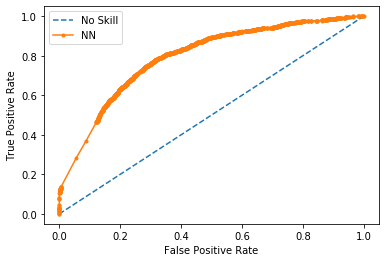

In [125]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

Model: f1=0.774 auc=0.822


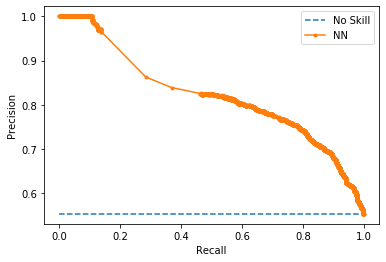

In [126]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Convolutional Neural Network</h2>

In [127]:
def create_conv_model(word_index, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(250, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(150, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(50, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),

    keras.layers.Dense(1, activation='sigmoid')])
    
    return model

In [128]:
model = create_conv_model(word_index, embedding_matrix=embedding_matrix, pre_trained=True)

In [129]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 121s 312ms/step - loss: 0.5082 - accuracy: 0.7498 - val_loss: 0.4493 - val_accuracy: 0.7969
Epoch 2/50
387/387 [==============================] - 128s 331ms/step - loss: 0.4032 - accuracy: 0.8149 - val_loss: 0.4093 - val_accuracy: 0.8179
Epoch 3/50
387/387 [==============================] - 124s 322ms/step - loss: 0.3681 - accuracy: 0.8333 - val_loss: 0.4044 - val_accuracy: 0.8147
Epoch 4/50
387/387 [==============================] - 132s 341ms/step - loss: 0.3411 - accuracy: 0.8435 - val_loss: 0.3777 - val_accuracy: 0.8272
Epoch 5/50
387/387 [==============================] - 135s 348ms/step - loss: 0.3191 - accuracy: 0.8542 - val_loss: 0.3845 - val_accuracy: 0.8256
Epoch 6/50
387/387 [==============================] - 129s 333ms/step - loss: 0.2989 - accuracy: 0.8619 - val_loss: 0.3790 - val_accuracy: 0.8265
Epoch 7/50
387/387 [==============================] - 135s 348ms/step - loss: 0.2880 - accuracy: 0.8673 - val_loss: 0.3923 -

In [130]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 18s 114ms/step - loss: 0.4004 - accuracy: 0.8261
[0.4003804624080658, 0.8260588049888611]


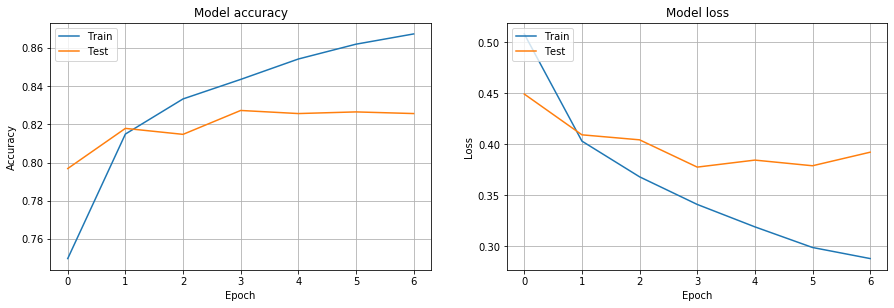

In [131]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [135]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i[0]>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 57.69%


<h3>Confusion Matrix</h3>

In [136]:
func_confusion_matrix(model, valid_y, valid_seq_x)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<h3>Classification repport</h3>

In [137]:
print(classification_report(valid_y, [1 if i[0]>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.92      0.60      0.73      2301
           1       0.75      0.96      0.84      2854

    accuracy                           0.80      5155
   macro avg       0.84      0.78      0.78      5155
weighted avg       0.83      0.80      0.79      5155



<h3>ROC and AUC Curve</h3>

In [138]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

ValueError: Found array with dim 3. Estimator expected <= 2.

<h3>Precision Recall Curve</h3>

In [ ]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Recurrent Neural Network – LSTM</h2>

In [139]:
def create_lstm_model(word_index, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.LSTM(100),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])
    
    return model

In [140]:
model = create_lstm_model(word_index)
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 290s 750ms/step - loss: 0.4293 - accuracy: 0.8067 - val_loss: 0.3254 - val_accuracy: 0.8781
Epoch 2/50
387/387 [==============================] - 321s 830ms/step - loss: 0.4106 - accuracy: 0.8192 - val_loss: 0.3887 - val_accuracy: 0.8455
Epoch 3/50
387/387 [==============================] - 275s 710ms/step - loss: 0.2833 - accuracy: 0.8858 - val_loss: 0.3679 - val_accuracy: 0.8565
Epoch 4/50
387/387 [==============================] - 297s 767ms/step - loss: 0.2134 - accuracy: 0.9108 - val_loss: 0.4084 - val_accuracy: 0.8348


In [141]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 13s 78ms/step - loss: 0.3865 - accuracy: 0.8440
[0.3864917457103729, 0.8440349102020264]


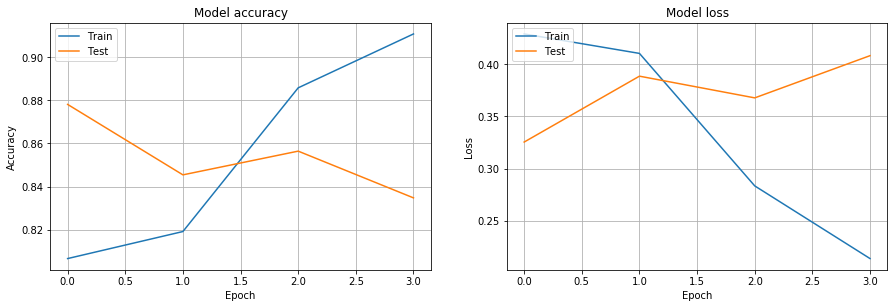

In [142]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [143]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 68.05%


<h3>Confusion Matrix</h3>

In [144]:
func_confusion_matrix(model, valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,1751,550
Actual Positive,254,2600


<h3>Classification repport</h3>

In [145]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      2301
           1       0.83      0.91      0.87      2854

    accuracy                           0.84      5155
   macro avg       0.85      0.84      0.84      5155
weighted avg       0.85      0.84      0.84      5155



<h3>ROC and AUC Curve</h3>

No Skill: ROC AUC=0.500
NN: ROC AUC=0.907


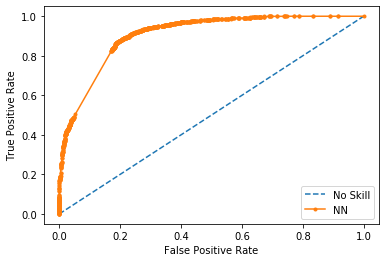

In [146]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

Model: f1=0.866 auc=0.918


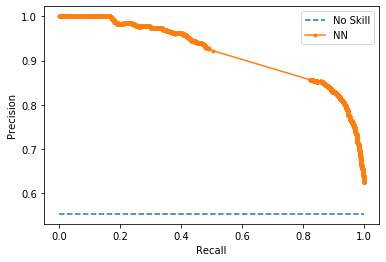

In [147]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>CNN – LSTM</h2>

In [148]:
def create_cnn_lstm_model(word_index, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.LSTM(100),
    keras.layers.Dense(1, activation='sigmoid')])
    
    return model

In [149]:
model = create_cnn_lstm_model(word_index)
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 267s 689ms/step - loss: 0.3854 - accuracy: 0.8354 - val_loss: 0.3031 - val_accuracy: 0.8668
Epoch 2/50
387/387 [==============================] - 290s 749ms/step - loss: 0.2537 - accuracy: 0.9003 - val_loss: 0.3531 - val_accuracy: 0.8555
Epoch 3/50
387/387 [==============================] - 263s 679ms/step - loss: 0.1979 - accuracy: 0.9194 - val_loss: 0.3539 - val_accuracy: 0.8704
Epoch 4/50
387/387 [==============================] - 264s 683ms/step - loss: 0.1751 - accuracy: 0.9276 - val_loss: 0.3596 - val_accuracy: 0.8565


In [150]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 7s 42ms/step - loss: 0.3560 - accuracy: 0.8551
[0.3560117781162262, 0.8550921678543091]


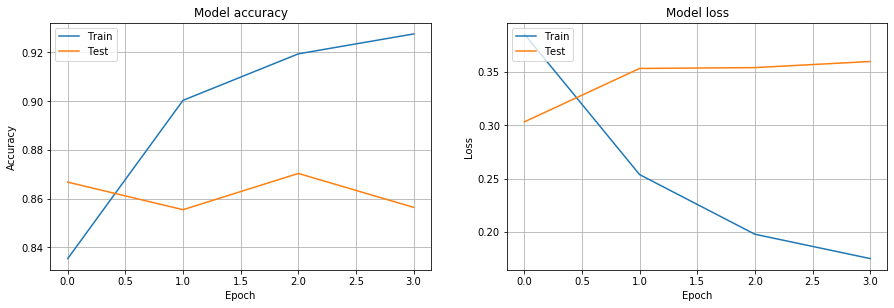

In [151]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [152]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 69.98%


<h3>Confusion Matrix</h3>

In [153]:
func_confusion_matrix(model, valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,1651,650
Actual Positive,97,2757


<h3>Classification repport</h3>

In [154]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.94      0.72      0.82      2301
           1       0.81      0.97      0.88      2854

    accuracy                           0.86      5155
   macro avg       0.88      0.84      0.85      5155
weighted avg       0.87      0.86      0.85      5155



<h3>ROC and AUC Curve</h3>

No Skill: ROC AUC=0.500
NN: ROC AUC=0.921


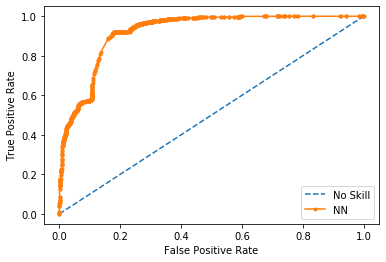

In [155]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

Model: f1=0.881 auc=0.924


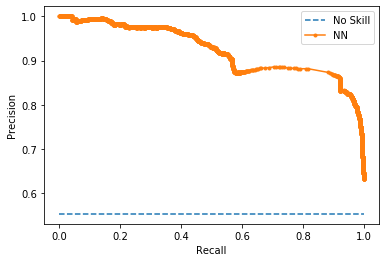

In [156]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Recurrent Neural Network – GRU</h2>

tf.keras.layers.GRU(
    units, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
    kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    recurrent_constraint=None, bias_constraint=None, dropout=0.0,
    recurrent_dropout=0.0, implementation=2, return_sequences=False,
    return_state=False, go_backwards=False, stateful=False, unroll=False,
    time_major=False, reset_after=True, **kwargs
)

In [157]:
def create_gru_model(word_index, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.GRU(100),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])
    
    return model

In [158]:
model = create_gru_model(word_index)
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 243s 629ms/step - loss: 0.4584 - accuracy: 0.7884 - val_loss: 0.3697 - val_accuracy: 0.8390
Epoch 2/50
387/387 [==============================] - 222s 573ms/step - loss: 0.2744 - accuracy: 0.8893 - val_loss: 0.3509 - val_accuracy: 0.8652
Epoch 3/50
387/387 [==============================] - 213s 551ms/step - loss: 0.2186 - accuracy: 0.9144 - val_loss: 0.3663 - val_accuracy: 0.8687
Epoch 4/50
387/387 [==============================] - 222s 573ms/step - loss: 0.1572 - accuracy: 0.9403 - val_loss: 0.3396 - val_accuracy: 0.8749
Epoch 5/50
387/387 [==============================] - 225s 581ms/step - loss: 0.1195 - accuracy: 0.9548 - val_loss: 0.3704 - val_accuracy: 0.8736
Epoch 6/50
387/387 [==============================] - 224s 580ms/step - loss: 0.0976 - accuracy: 0.9640 - val_loss: 0.4035 - val_accuracy: 0.8778
Epoch 7/50
387/387 [==============================] - 253s 655ms/step - loss: 0.0839 - accuracy: 0.9689 - val_loss: 0.3993 -

In [159]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 10s 61ms/step - loss: 0.3708 - accuracy: 0.8846
[0.3707728981971741, 0.8845781087875366]


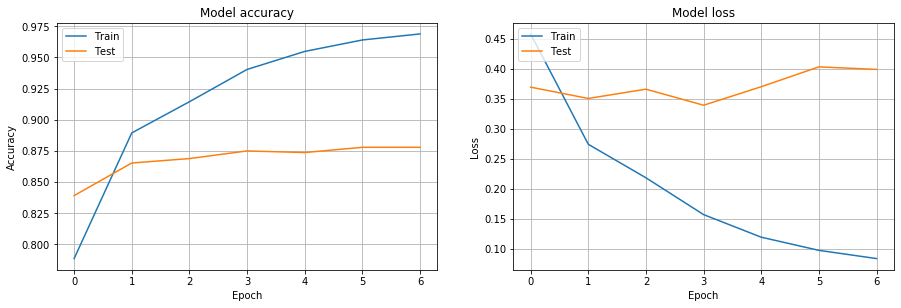

In [160]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [161]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 76.31%


<h3>Confusion Matrix</h3>

In [162]:
func_confusion_matrix(model, valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,1837,464
Actual Positive,131,2723


<h3>Classification repport</h3>

In [163]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2301
           1       0.85      0.95      0.90      2854

    accuracy                           0.88      5155
   macro avg       0.89      0.88      0.88      5155
weighted avg       0.89      0.88      0.88      5155



<h3>ROC and AUC Curve</h3>

No Skill: ROC AUC=0.500
NN: ROC AUC=0.942


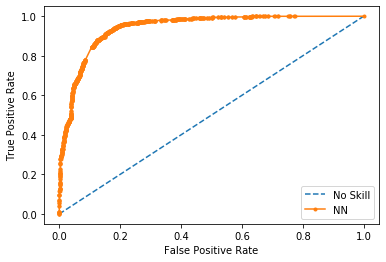

In [164]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

Model: f1=0.902 auc=0.945


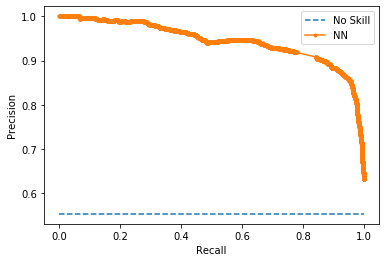

In [165]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Bidirectional RNN</h2>

In [166]:
def create_bidirec_rnn_model(word_index, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.SimpleRNN(100)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])
    
    return model

In [167]:
model = create_bidirec_rnn_model(word_index)
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 240s 620ms/step - loss: 0.6402 - accuracy: 0.6232 - val_loss: 0.5475 - val_accuracy: 0.7090
Epoch 2/50
387/387 [==============================] - 257s 665ms/step - loss: 0.4669 - accuracy: 0.7873 - val_loss: 0.4957 - val_accuracy: 0.7511
Epoch 3/50
387/387 [==============================] - 308s 796ms/step - loss: 0.3268 - accuracy: 0.8740 - val_loss: 0.5391 - val_accuracy: 0.7517
Epoch 4/50
387/387 [==============================] - 246s 635ms/step - loss: 0.2398 - accuracy: 0.9067 - val_loss: 0.5731 - val_accuracy: 0.7488
Epoch 5/50
387/387 [==============================] - 230s 595ms/step - loss: 0.2624 - accuracy: 0.8978 - val_loss: 0.5460 - val_accuracy: 0.7601


In [168]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 7s 41ms/step - loss: 0.5482 - accuracy: 0.7692
[0.548166811466217, 0.7691561579704285]


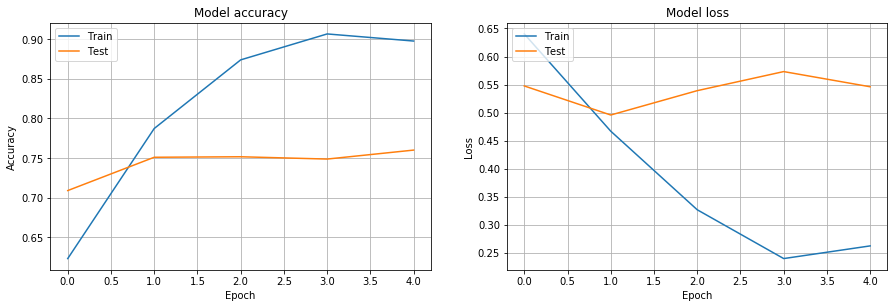

In [169]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [170]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 52.64%


<h3>Confusion Matrix</h3>

In [171]:
func_confusion_matrix(model, valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,1543,758
Actual Positive,432,2422


<h3>Classification repport</h3>

In [172]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.78      0.67      0.72      2301
           1       0.76      0.85      0.80      2854

    accuracy                           0.77      5155
   macro avg       0.77      0.76      0.76      5155
weighted avg       0.77      0.77      0.77      5155



<h3>ROC and AUC Curve</h3>

No Skill: ROC AUC=0.500
NN: ROC AUC=0.823


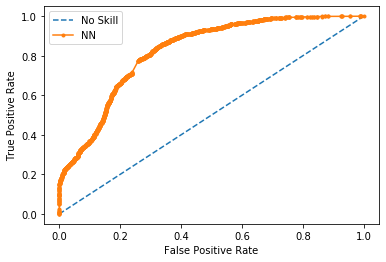

In [173]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

Model: f1=0.803 auc=0.837


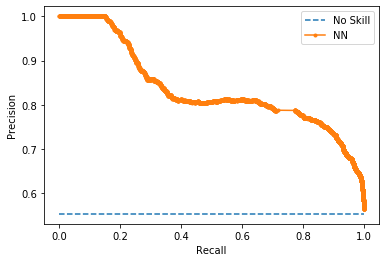

In [174]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Bidirectional LSTM</h2>

In [175]:
def create_bidirec_lstm_model(word_index, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.LSTM(100)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])
    
    return model

In [176]:
model = create_bidirec_lstm_model(word_index)
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 282s 728ms/step - loss: 0.4560 - accuracy: 0.8001 - val_loss: 0.3576 - val_accuracy: 0.8577
Epoch 2/50
387/387 [==============================] - 294s 761ms/step - loss: 0.2852 - accuracy: 0.8902 - val_loss: 0.3357 - val_accuracy: 0.8639
Epoch 3/50
387/387 [==============================] - 276s 714ms/step - loss: 0.1878 - accuracy: 0.9338 - val_loss: 0.3399 - val_accuracy: 0.8619
Epoch 4/50
387/387 [==============================] - 288s 745ms/step - loss: 0.1308 - accuracy: 0.9534 - val_loss: 0.3491 - val_accuracy: 0.8668
Epoch 5/50
387/387 [==============================] - 331s 856ms/step - loss: 0.1114 - accuracy: 0.9587 - val_loss: 0.3797 - val_accuracy: 0.8739


In [177]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 13s 77ms/step - loss: 0.3398 - accuracy: 0.8888
[0.33981853723526, 0.8888458013534546]


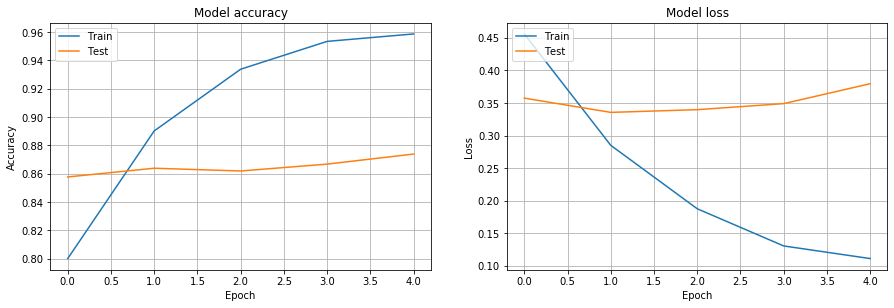

In [178]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [179]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 77.39%


<h3>Confusion Matrix</h3>

In [180]:
func_confusion_matrix(model, valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,1952,349
Actual Positive,224,2630


<h3>Classification repport</h3>

In [181]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      2301
           1       0.88      0.92      0.90      2854

    accuracy                           0.89      5155
   macro avg       0.89      0.88      0.89      5155
weighted avg       0.89      0.89      0.89      5155



<h3>ROC and AUC Curve</h3>

No Skill: ROC AUC=0.500
NN: ROC AUC=0.943


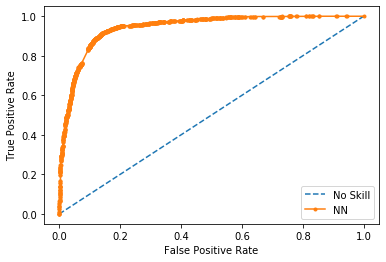

In [182]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

Model: f1=0.902 auc=0.945


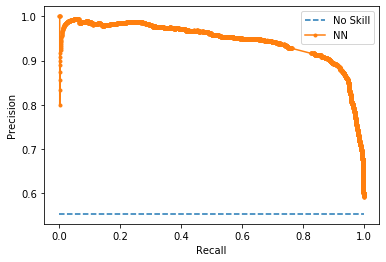

In [183]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Bidirectional GRU</h2>

In [224]:
def create_bidirec_gru_model(word_index, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.GRU(100)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])
    
    return model

In [225]:
model = create_bidirec_gru_model(word_index)#, embedding_matrix=embedding_matrix, pre_trained=True)
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 227s 587ms/step - loss: 0.4735 - accuracy: 0.7941 - val_loss: 0.3718 - val_accuracy: 0.8490
Epoch 2/50
387/387 [==============================] - 248s 640ms/step - loss: 0.2985 - accuracy: 0.8845 - val_loss: 0.3511 - val_accuracy: 0.8626
Epoch 3/50
387/387 [==============================] - 262s 676ms/step - loss: 0.1830 - accuracy: 0.9296 - val_loss: 0.3495 - val_accuracy: 0.8636
Epoch 4/50
387/387 [==============================] - 257s 664ms/step - loss: 0.1200 - accuracy: 0.9542 - val_loss: 0.3659 - val_accuracy: 0.8645
Epoch 5/50
387/387 [==============================] - 253s 653ms/step - loss: 0.1060 - accuracy: 0.9603 - val_loss: 0.4293 - val_accuracy: 0.8335
Epoch 6/50
387/387 [==============================] - 272s 703ms/step - loss: 0.0930 - accuracy: 0.9638 - val_loss: 0.4052 - val_accuracy: 0.8720


In [226]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 11s 71ms/step - loss: 0.3635 - accuracy: 0.8848
[0.3635362684726715, 0.8847720623016357]


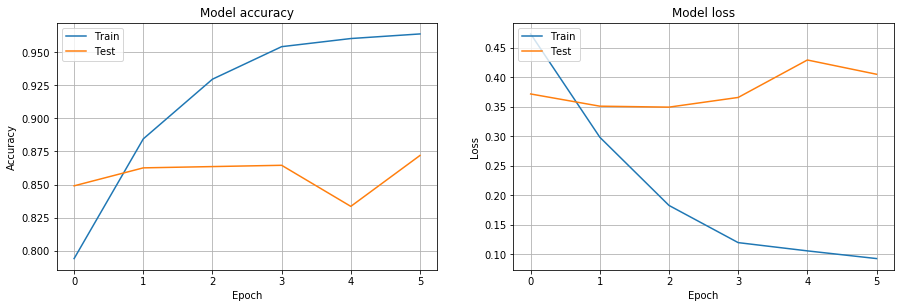

In [227]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [228]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 76.59%


<h3>Confusion Matrix</h3>

In [229]:
func_confusion_matrix(model,valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,1957,344
Actual Positive,250,2604


<h3>Classification repport</h3>

In [230]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2301
           1       0.88      0.91      0.90      2854

    accuracy                           0.88      5155
   macro avg       0.89      0.88      0.88      5155
weighted avg       0.88      0.88      0.88      5155



<h3>ROC and AUC Curve</h3>

No Skill: ROC AUC=0.500
NN: ROC AUC=0.946


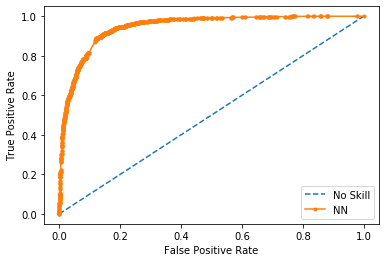

In [231]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

Model: f1=0.898 auc=0.950


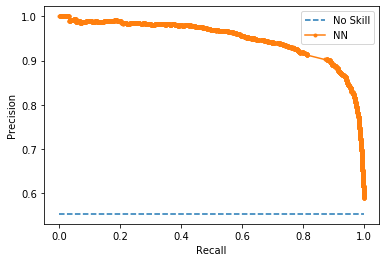

In [232]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Recurrent Convolutional Neural Network</h2>

In [215]:
def create_rcnn(word_index, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')])
    
    
    return model

In [216]:
model = create_rcnn(word_index, embedding_matrix=embedding_matrix, pre_trained = True)
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 179s 462ms/step - loss: 0.4160 - accuracy: 0.8102 - val_loss: 0.2981 - val_accuracy: 0.8771
Epoch 2/50
387/387 [==============================] - 185s 478ms/step - loss: 0.2960 - accuracy: 0.8785 - val_loss: 0.2794 - val_accuracy: 0.8833
Epoch 3/50
387/387 [==============================] - 184s 475ms/step - loss: 0.2600 - accuracy: 0.8956 - val_loss: 0.2608 - val_accuracy: 0.8949
Epoch 4/50
387/387 [==============================] - 182s 471ms/step - loss: 0.2417 - accuracy: 0.9010 - val_loss: 0.2605 - val_accuracy: 0.8946
Epoch 5/50
387/387 [==============================] - 185s 478ms/step - loss: 0.2313 - accuracy: 0.9058 - val_loss: 0.2513 - val_accuracy: 0.8952
Epoch 6/50
387/387 [==============================] - 196s 505ms/step - loss: 0.2184 - accuracy: 0.9130 - val_loss: 0.2543 - val_accuracy: 0.8978
Epoch 7/50
387/387 [==============================] - 185s 478ms/step - loss: 0.2077 - accuracy: 0.9146 - val_loss: 0.2502 -

In [217]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

162/162 [==============================] - 25s 155ms/step - loss: 0.2368 - accuracy: 0.9102
[0.23679937422275543, 0.9101842641830444]


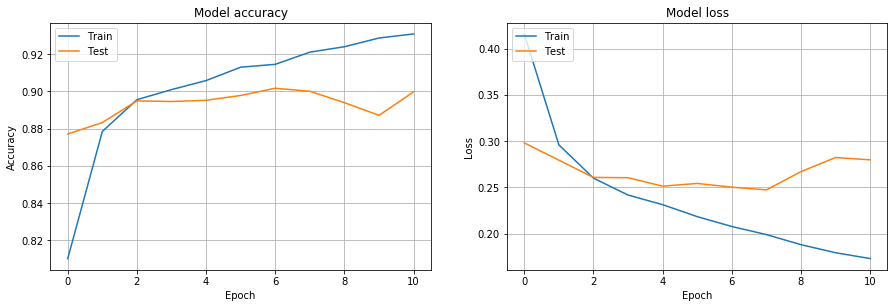

In [218]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [219]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 81.75%


<h3>Confusion Matrix</h3>

In [220]:
func_confusion_matrix(model, valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,2020,281
Actual Positive,182,2672


<h3>Classification repport</h3>

In [221]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2301
           1       0.90      0.94      0.92      2854

    accuracy                           0.91      5155
   macro avg       0.91      0.91      0.91      5155
weighted avg       0.91      0.91      0.91      5155



<h3>ROC and AUC Curve</h3>

No Skill: ROC AUC=0.500
NN: ROC AUC=0.968


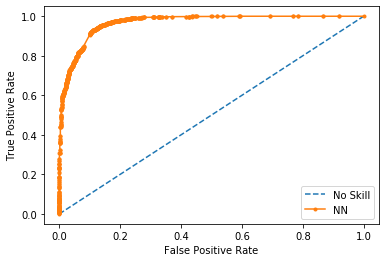

In [222]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

<h2>Recurrent Convolutional Neural Network</h2>

In [233]:
def create_rcnn(word_index, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')])
    
    
    return model

In [ ]:
model = create_rcnn(word_index, embedding_matrix=embedding_matrix, pre_trained = True)
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 466s 1s/step - loss: 0.4247 - accuracy: 0.8047 - val_loss: 0.3750 - val_accuracy: 0.8312
Epoch 2/50
387/387 [==============================] - 403s 1s/step - loss: 0.3142 - accuracy: 0.8693 - val_loss: 0.2871 - val_accuracy: 0.8839
Epoch 3/50
387/387 [==============================] - 359s 928ms/step - loss: 0.2801 - accuracy: 0.8881 - val_loss: 0.3147 - val_accuracy: 0.8594
Epoch 4/50
387/387 [==============================] - 459s 1s/step - loss: 0.2686 - accuracy: 0.8919 - val_loss: 0.2708 - val_accuracy: 0.8901
Epoch 5/50
387/387 [==============================] - 369s 954ms/step - loss: 0.2487 - accuracy: 0.8996 - val_loss: 0.2866 - val_accuracy: 0.8807
Epoch 6/50
387/387 [==============================] - ETA: 0s - loss: 0.2456 - accuracy: 0.8978

In [ ]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)

In [ ]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [219]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

Cohen's kappa: 81.75%


<h3>Confusion Matrix</h3>

In [220]:
func_confusion_matrix(model, valid_y, valid_seq_x)

,Predicted Negative,Predicted Positive
Actual Negative,2020,281
Actual Positive,182,2672


<h3>Classification repport</h3>

In [221]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2301
           1       0.90      0.94      0.92      2854

    accuracy                           0.91      5155
   macro avg       0.91      0.91      0.91      5155
weighted avg       0.91      0.91      0.91      5155



<h3>ROC and AUC Curve</h3>

No Skill: ROC AUC=0.500
NN: ROC AUC=0.968


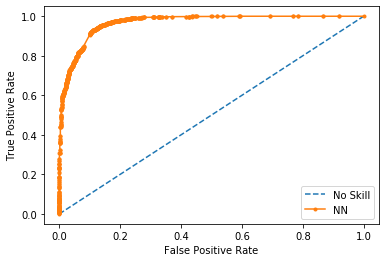

In [222]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

Model: f1=0.920 auc=0.972


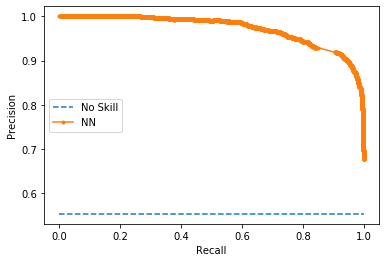

In [223]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

Model: f1=0.920 auc=0.972


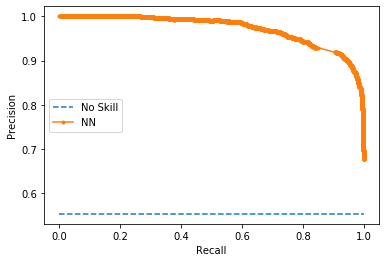

In [223]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Transformers</h2>

huggingface

In [202]:
import torch

In [203]:
camembert = torch.hub.load('pytorch/fairseq', 'camembert.v0')

Using cache found in /home/chris/.cache/torch/hub/pytorch_fairseq_master


In [204]:
from simpletransformers.classification import ClassificationModel

In [205]:
# Create a ClassificationModel
model = ClassificationModel('camembert', 'camembert-base', use_cuda=False,  num_labels=2)

/home/chris/.local/lib/python3.6/site-packages/simpletransformers/classification/classification_model.py:176: UserWarning: use_multiprocessing automatically disabled as camembert fails when using multiprocessing for feature conversion.
  f"use_multiprocessing automatically disabled as {model_type}"


In [ ]:
self.args = {
    "output_dir": "outputs/",
    "cache_dir": "cache_dir/",

    "fp16": True,
    "fp16_opt_level": "O1",
    "max_seq_length": 128,
    "train_batch_size": 8,
    "gradient_accumulation_steps": 1,
    "eval_batch_size": 8,
    "num_train_epochs": 1,
    "weight_decay": 0,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,

    "logging_steps": 50,
    "save_steps": 2000,

    "overwrite_output_dir": False,
    "reprocess_input_data": False,
    "evaluate_during_training": False,

    "process_count": cpu_count() - 2 if cpu_count() > 2 else 1,
    "n_gpu": 1,
}

In [ ]:
import pandas as pd


prefix = 'data/'

train_df = pd.read_csv(prefix + 'train.csv', header=None)
train_df.head()

eval_df = pd.read_csv(prefix + 'test.csv', header=None)
eval_df.head()

train_df[0] = (train_df[0] == 2).astype(int)
eval_df[0] = (eval_df[0] == 2).astype(int)

train_df = pd.DataFrame({
    'text': train_df[1].replace(r'\n', ' ', regex=True),
    'label':train_df[0]
})

print(train_df.head())

eval_df = pd.DataFrame({
    'text': eval_df[1].replace(r'\n', ' ', regex=True),
    'label':eval_df[0]
})

print(eval_df.head())

In [ ]:
df.shape[0]*0.8

In [ ]:
# Create a TransformerModel with modified attributes
model = TransformerModel('roberta', 'roberta-base', num_labels=4, args={'learning_rate':1e-5, 'num_train_epochs': 2, 'reprocess_input_data': True, 'overwrite_output_dir': True})


In [ ]:
df.reset_index(inplace=True)

In [208]:
df.shape[0]*0.8 , df.shape[0]*0.2

(16496.0, 4124.0)

In [209]:
x_train = df[["mails", "label"]].iloc[ :16496]
x_test = df[["mails", "label"]].iloc[16496:]

In [ ]:
x_train.shape

In [211]:
# Train the model
model.train_model(x_train)

/home/chris/.local/lib/python3.6/site-packages/simpletransformers/classification/classification_model.py:250: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


ValueError: too many dimensions 'str'

In [212]:
result, model_outputs, wrong_predictions = model.eval_model(x_test)

/home/chris/.local/lib/python3.6/site-packages/simpletransformers/classification/classification_model.py:624: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


ValueError: too many dimensions 'str'

In [213]:
result

NameError: name 'result' is not defined

In [ ]:
def func_precision_recall(result):
    
    tn, fp, fn, tp = result["tn"], result["fp"], result["fn"], result["tp"]
    
    print('''     Predicted       Predicted  
                 NO               YES
        Real   TN={}          FP={}
        NO     
        Real   FN={}           TP={}
        YES       '''.format(tn, fp, fn, tp))
    print('''
                  TP                     
    Precision = _______ = {}%    
                 TP+FP       


               TP
    Recall = ______  = {}%
              FN+TP           '''.format(round(tp/(tp+fp)*100,2), round(tp/(fn+tp)*100,2)))
    return round(tp/(tp+fp)*100,2), round(tp/(fn+tp)*100,2)


In [ ]:
func_precision_recall(result)

<h3>Cohen’s kappa</h3>

In [ ]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
func_confusion_matrix(model, valid_y, valid_seq_x)

<h3>Classification repport</h3>

In [ ]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

<h3>ROC and AUC Curve</h3>

In [ ]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Pre-Trained transformers models</h2>

bert / roberta / albert / camembert / ulmfit / gpt-2 

<h3>Cohen’s kappa</h3>

In [ ]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}"

<h3>Confusion Matrix</h3>

In [ ]:
func_confusion_matrix(model, valid_y, valid_seq_x)

<h3>Classification repport</h3>

In [ ]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

<h3>ROC and AUC Curve</h3>

In [ ]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h3>Reinforcement Learning</h3>

<h3>Cohen’s kappa</h3>

In [ ]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}"

<h3>Confusion Matrix</h3>

In [ ]:
func_confusion_matrix(model, valid_y, valid_seq_x)

<h3>Classification repport</h3>

In [ ]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

<h3>ROC and AUC Curve</h3>

In [ ]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h3>Autokeras</h3>

<h2>Knowledge Graphs</h2>